# Neural networks pruning
State-of-the-art neural networks nowadays have become extremely parameterized in order to maximize the prediction accuracy. However, the model also becomes costly to run and the inference latency becomes a bottleneck. On resource-constrained edge devices, the model has a lot of restrictions and cannot be parameterized as much as we can.

Sparse neural networks could perform as good as dense neural network with respect to the prediction accuracy, and the inference latency becomes much lower theoretically due to its small model size.

Neural network pruning is a method to create sparse neural networks from pre-trained dense neural networks. It is the process of deleting parameters from an existing neural network, which might involve removing individual parameters or groups of parameters.

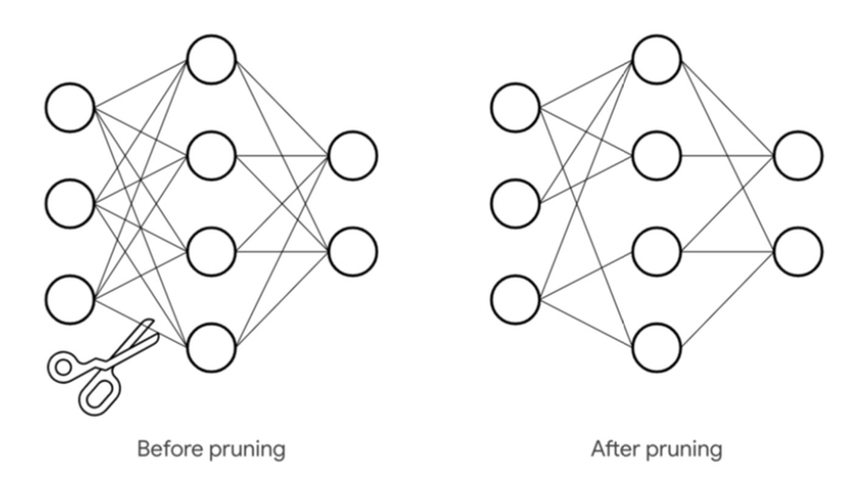

Today, we'll use PyTorch bultin prunning tools. Note, that there are a lot of other tools you can use for this purpose (for example last week's OpenVINO). Use this link for PyTorch prunning reference and documentation: https://pytorch.org/tutorials/intermediate/pruning_tutorial.html

First, import nessessery libraries.

In [32]:
import torch
import time
import numpy as np
import tqdm

from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, RandomRotation
from typing import Union, List, Tuple, Any
from abc import ABC, abstractmethod
import torch.nn.functional as F

Let's start with pretrained model. As usual, we'll use simple CNN model (like in Laboratory 3) and MNIST dataset. Don't use sequential blocks!

Train model for 5 epochs - you should get around ~98% accuracy.

Name the final trained model `CNN_MNIST`.

In [33]:
class CNN(nn.Module):
    def __init__(self, input_shape, num_of_cls):
        super().__init__()
        ch_in = input_shape[0]
        self.conv1 = nn.Conv2d(ch_in, 32, 3, padding=(1, 1))  # shape [32,28,28]
        self.conv2 = nn.Conv2d(32, 64, 3, padding=(1, 1))  # shape [64,14,14]
        self.conv3 = nn.Conv2d(64, 128, 3)  # shape [128,5,5]

        self.batch1 = nn.BatchNorm2d(32)
        self.batch2 = nn.BatchNorm2d(64)
        self.batch3 = nn.BatchNorm2d(128)

        self.classification_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 5 * 5, num_of_cls),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.batch1(self.conv1(x))), (2, 2))
        x = F.max_pool2d(F.relu(self.batch2(self.conv2(x))), (2, 2))
        x = F.relu(self.batch3(self.conv3(x)))
        y = self.classification_head(x)
        return y

In [34]:
torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Updated batch size
batch_size = 128

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Updated DataLoader instances with the new batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

CNN_MNIST = CNN(input_shape=(1, 28, 28), num_of_cls=10).to(torch_device)
loss_fcn = nn.CrossEntropyLoss()
optimizer = optim.Adam(CNN_MNIST.parameters(), lr=0.001)

def train(epoch):
    CNN_MNIST.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(torch_device), target.to(torch_device)

        optimizer.zero_grad()
        output = CNN_MNIST(data)
        loss = loss_fcn(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test():
    CNN_MNIST.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(torch_device), target.to(torch_device)
            output = CNN_MNIST(data)
            test_loss += loss_fcn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset) * 100.0

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

def training(num_epochs=5):
    history = {'train_loss': [], 'test_loss': [], 'accuracy': []}
    for epoch in range(1, num_epochs + 1):
        train(epoch)
        test()
    return CNN_MNIST, history

CNN_MNIST, history = training(num_epochs=1)

model_save_path = './model.pth'
torch.save(CNN_MNIST.state_dict(), model_save_path)

print(f'Model and optimizer saved at {model_save_path}.')


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309527
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.583160
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.479118
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.496605
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.480580

Test set: Average loss: 0.0117, Accuracy: 9798/10000 (97.98%)

Model and optimizer saved at ./model.pth.


Now, we can start our prunning. First...

# Unstructured Pruning
When talking about the cost of neural networks, the count of parameters is surely one of the most widely used metrics, along with FLOPS (floating-point operations per second). It is indeed intimidating to see networks displaying astronomical amounts of weights (up to billions for some), often correlated with stellar performance. Therefore, it is quite intuitive to aim at reducing directly this count by removing parameters themselves.

Directly pruning parameters has many advantages. First, it is simple, since replacing the value of their weight with zero, within the parameter tensors, is enough to prune a connection. Moreover it is easy to do without hurting the performance of the network. As pruning weights is not limited by any constraint at all and is the finest way to prune a network, such a paradigm is called **unstructured pruning**.

Let's start with simplest case - random unstructured pruning!

First - create net model `CNN_MNIST_RND` and load trained weigts to it, with `load_state_dict` function.

Then, for each Convolutional Layer of this network, perform random unstructured prunning for 25% of all weights.

To do that, use `prune.random_unstructured()` function.
- The network layer is passed as the first argument to the function (you can get ti with `model.layer_name`;
- `name` identifies the parameter within that module using its string identifier - we update `weight`
-  and `amount` indicates the percentage of connections to prune (a float between 0. and 1.)

In [35]:
import torch.nn.utils.prune as prune

# Assuming CNN_MNIST_RND is already instantiated and loaded with trained weights

# Define your CNN model
CNN_MNIST_RND = CNN(input_shape=(1, 28, 28), num_of_cls=10)

# Load the trained weights using load_state_dict
CNN_MNIST_RND.load_state_dict(torch.load(model_save_path))

# Define the optimizer
optimizer_RND = optim.Adam(CNN_MNIST_RND.parameters(), lr=0.001)

# Prune each convolutional layer with random unstructured pruning
for name, module in CNN_MNIST_RND.named_children():
    if isinstance(module, nn.Conv2d):
        # Specify the amount of weights to prune (25% in this case)
        prune_amount = 0.25

        # Use random unstructured pruning
        prune.random_unstructured(module, name='weight', amount=prune_amount)

# You can print the model to see the pruning masks
print(CNN_MNIST_RND)

# Continue with your training loop as before, and the optimizer will take care of updating the pruned weights
# Be sure to use the same optimizer instance (optimizer_RND) during training


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (classification_head): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3200, out_features=10, bias=True)
    (2): Softmax(dim=1)
  )
)


Did it work? Let's find out!

First - evaluate both `CNN_MNIST_RND` and `CNN_MNIST` networks on testing dataset and print the accuracies. Compare it.

Then, calculate the sparsity for `CNN_MNIST_RND` model with following function.

Finally, compare `model.layer_name.weight` atributes for both networks for selected layer. Are some weights zeroed?

In [36]:
def test(model, dataloader, loss_function=loss_fcn, device=torch_device):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_function(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(dataloader.dataset)
    accuracy = correct / len(dataloader.dataset) * 100.0

    return test_loss, accuracy


In [37]:
CNN_MNIST_RND.to(torch_device)
_, test_acc_CNN_MNIST = test(CNN_MNIST, test_loader)
_, test_acc_CNN_MNIST_RND = test(CNN_MNIST_RND, test_loader)

# Print accuracies
print(f'Accuracy for CNN_MNIST: {test_acc_CNN_MNIST}')
print(f'Accuracy for CNN_MNIST_RND: {test_acc_CNN_MNIST_RND}')

# Calculate sparsity for CNN_MNIST_RND
sparsity_CNN_MNIST_RND = 100. * float(torch.sum(CNN_MNIST_RND.conv1.weight == 0)
                                      + torch.sum(CNN_MNIST_RND.conv2.weight == 0)
                                      + torch.sum(CNN_MNIST_RND.conv3.weight == 0)) / float(CNN_MNIST_RND.conv1.weight.nelement()
                                      + CNN_MNIST_RND.conv2.weight.nelement()
                                      + CNN_MNIST_RND.conv3.weight.nelement())

print("Sparsity in CNN_MNIST_RND: {:.2f}%".format(sparsity_CNN_MNIST_RND))

# Print model.layer_name.weight for both networks
print("Weights for CNN_MNIST.conv1.weight:")
print(CNN_MNIST.conv1.weight)

print("\nWeights for CNN_MNIST_RND.conv1.weight:")
print(CNN_MNIST_RND.conv1.weight)


Accuracy for CNN_MNIST: 97.98
Accuracy for CNN_MNIST_RND: 38.2
Sparsity in CNN_MNIST_RND: 25.00%
Weights for CNN_MNIST.conv1.weight:
Parameter containing:
tensor([[[[-0.0078,  0.2926,  0.1742],
          [-0.1920, -0.1143, -0.1030],
          [ 0.1508, -0.1046, -0.2345]]],


        [[[ 0.0145,  0.2362,  0.1000],
          [-0.2635,  0.0929,  0.2583],
          [ 0.3377, -0.1168,  0.3185]]],


        [[[-0.1697,  0.0569,  0.0396],
          [-0.2262,  0.0176,  0.1480],
          [ 0.0195, -0.2436,  0.0807]]],


        [[[-0.1601, -0.1009, -0.0630],
          [-0.1180, -0.1189, -0.2068],
          [ 0.0334,  0.2616,  0.2186]]],


        [[[-0.2740,  0.2373,  0.1395],
          [ 0.1072,  0.2865,  0.1319],
          [ 0.2788,  0.1867, -0.2780]]],


        [[[-0.0259,  0.1682,  0.0311],
          [ 0.1117, -0.1438, -0.1678],
          [ 0.2892,  0.0241, -0.1905]]],


        [[[-0.0058, -0.0677,  0.0470],
          [-0.2861, -0.0561, -0.1117],
          [ 0.1074,  0.1778, -0.2645]]],


Well, prunning random weights is simple but unefficient. A real challenge in pruning is determining what to prune. If you are removing weights or nodes from a model, you want the parameters you remove to be less useful. There are different heuristics and methods of determining which nodes are less important and can be removed with minimal effect on accuracy.

For that, we can use L1 norm to find the smallest (least important) parameters.

First - create net model `CNN_MNIST_L1` and load trained weigts to it, with `load_state_dict` function.

Then, for each Convolutional Layer of this network, perform L1 unstructured prunning for 25% of all weights.

To do that, replace `prune.random_unstructured()` with `prune.l1_unstructured()` function. Evaluate the new network, calculate its sparsity and compare it's weights.

In [38]:
import torch.nn.utils.prune as prune

# Create CNN_MNIST_L1 model and load trained weights
CNN_MNIST_L1 = CNN(input_shape=(1, 28, 28), num_of_cls=10).to(torch_device)
CNN_MNIST_L1.load_state_dict(torch.load(model_save_path))

# Define the optimizer
optimizer_L1 = optim.Adam(CNN_MNIST_L1.parameters(), lr=0.001)

# L1 unstructured pruning for each Convolutional Layer
for name, module in CNN_MNIST_L1.named_children():
    if isinstance(module, nn.Conv2d):
        # Specify the amount of weights to prune (25% in this case)
        prune_amount = 0.25

        # Use L1 unstructured pruning
        prune.l1_unstructured(module, name='weight', amount=prune_amount)

# Evaluate the model
test_loss_CNN_MNIST_L1, accuracy_CNN_MNIST_L1 = test(CNN_MNIST_L1, test_loader, loss_fcn, torch_device)

# Calculate sparsity for CNN_MNIST_L1
sparsity_CNN_MNIST_L1 = 100. * float(torch.sum(CNN_MNIST_L1.conv1.weight == 0)
                                   + torch.sum(CNN_MNIST_L1.conv2.weight == 0)
                                   + torch.sum(CNN_MNIST_L1.conv3.weight == 0)) / float(CNN_MNIST_L1.conv1.weight.nelement()
                                   + CNN_MNIST_L1.conv2.weight.nelement()
                                   + CNN_MNIST_L1.conv3.weight.nelement())

# Print results
print('Accuracy for CNN_MNIST: {:.2f}%'.format(test_acc_CNN_MNIST))
print('Accuracy for CNN_MNIST_L1: {:.2f}%'.format(accuracy_CNN_MNIST_L1))
print('Sparsity in CNN_MNIST_L1: {:.2f}%'.format(sparsity_CNN_MNIST_L1))

# Compare model.layer_name.weight for CNN_MNIST and CNN_MNIST_L1 networks
print("\nWeights for CNN_MNIST.conv1.weight:")
print(CNN_MNIST.conv1.weight)

print("\nWeights for CNN_MNIST_L1.conv1.weight:")
print(CNN_MNIST_L1.conv1.weight)


Accuracy for CNN_MNIST: 97.98%
Accuracy for CNN_MNIST_L1: 95.18%
Sparsity in CNN_MNIST_L1: 25.00%

Weights for CNN_MNIST.conv1.weight:
Parameter containing:
tensor([[[[-0.0078,  0.2926,  0.1742],
          [-0.1920, -0.1143, -0.1030],
          [ 0.1508, -0.1046, -0.2345]]],


        [[[ 0.0145,  0.2362,  0.1000],
          [-0.2635,  0.0929,  0.2583],
          [ 0.3377, -0.1168,  0.3185]]],


        [[[-0.1697,  0.0569,  0.0396],
          [-0.2262,  0.0176,  0.1480],
          [ 0.0195, -0.2436,  0.0807]]],


        [[[-0.1601, -0.1009, -0.0630],
          [-0.1180, -0.1189, -0.2068],
          [ 0.0334,  0.2616,  0.2186]]],


        [[[-0.2740,  0.2373,  0.1395],
          [ 0.1072,  0.2865,  0.1319],
          [ 0.2788,  0.1867, -0.2780]]],


        [[[-0.0259,  0.1682,  0.0311],
          [ 0.1117, -0.1438, -0.1678],
          [ 0.2892,  0.0241, -0.1905]]],


        [[[-0.0058, -0.0677,  0.0470],
          [-0.2861, -0.0561, -0.1117],
          [ 0.1074,  0.1778, -0.2645]]]

The sparsity of `CNN_MNIST_L1` and `CNN_MNIST_RND` should be the same, but the accuracy for L1 prunning should be much better!

If it's not, you got lucky! Try to rerun random prunning :)

# Structured Pruning

Unstructured pruning results in a sparse neural network, which, while lower in terms of parameter count, may not be configured in a way that promotes speed improvements. Zeroing out the parameters saves memory but may not necessarily improve computing performance because we end up conducting the same number of matrix multiplications as before. To make use of technology and software that is specialized for dense processing, **structured pruning** algorithms consider parameters in groups, deleting entire neurons, filters, or channels.

For Convolutional Neural Networks, the most Hardware-efficient method is deleting entire channels. This operation can be very damaging for network accuracy, so we'll use L2 norm to calculate magnitude of each channel.

First - create net model `CNN_MNIST_STRUCT` and load trained weigts to it, with `load_state_dict` function.

Then, for each Convolutional Layer of this network, perform L2 structured prunning for 1/8 of all weights.

To do that, replace `prune.random_unstructured()` with `prune.ln_structured()` function. Whis fucntion, exept of layer, `name` and `amonut` takes two additional parameters:
- `n` which defines the Ln norm type, so we use `n=2`
- `dim` which defines the index of the dim along which we define channels to prune. the 0th axis corresponds to the output channels of the convolutional layer, so we use `dim=0`.

Evaluate the new network, calculate its sparsity and compare it's weights.




In [39]:
CNN_MNIST_STRUCT = CNN(input_shape=(1, 28, 28), num_of_cls=10).to(torch_device)
CNN_MNIST_STRUCT.load_state_dict(torch.load(model_save_path))

optimizer_STRUCT = optim.Adam(CNN_MNIST_STRUCT.parameters(), lr=0.001)

for name, module in CNN_MNIST_STRUCT.named_children():
    if isinstance(module, nn.Conv2d):
        prune_amount = 0.25

        # Use L2 structured pruning
        prune.ln_structured(module, name="weight", amount=prune_amount, n=2, dim=0)

# Evaluate the model
test_loss_CNN_MNIST_STRUCT, accuracy_CNN_MNIST_STRUCT = test(
    CNN_MNIST_STRUCT, test_loader, loss_fcn, torch_device
)

# Calculate sparsity for CNN_MNIST_STRUCT
sparsity_CNN_MNIST_STRUCT = (
    100.0
    * float(
        torch.sum(CNN_MNIST_STRUCT.conv1.weight == 0)
        + torch.sum(CNN_MNIST_STRUCT.conv2.weight == 0)
        + torch.sum(CNN_MNIST_STRUCT.conv3.weight == 0)
    )
    / float(
        CNN_MNIST_STRUCT.conv1.weight.nelement()
        + CNN_MNIST_STRUCT.conv2.weight.nelement()
        + CNN_MNIST_STRUCT.conv3.weight.nelement()
    )
)

# Print results
print("Accuracy for CNN_MNIST_STRUCT: {:.2f}%".format(accuracy_CNN_MNIST_STRUCT))
print("Sparsity in CNN_MNIST_STRUCT: {:.2f}%".format(sparsity_CNN_MNIST_STRUCT))

# Compare model.layer_name.weight for CNN_MNIST and CNN_MNIST_STRUCT networks
print("\nWeights for CNN_MNIST.conv1.weight:")
print(CNN_MNIST.conv1.weight)

print("\nWeights for CNN_MNIST_STRUCT.conv1.weight:")
print(CNN_MNIST_STRUCT.conv1.weight)

Accuracy for CNN_MNIST_STRUCT: 82.12%
Sparsity in CNN_MNIST_STRUCT: 25.00%

Weights for CNN_MNIST.conv1.weight:
Parameter containing:
tensor([[[[-0.0078,  0.2926,  0.1742],
          [-0.1920, -0.1143, -0.1030],
          [ 0.1508, -0.1046, -0.2345]]],


        [[[ 0.0145,  0.2362,  0.1000],
          [-0.2635,  0.0929,  0.2583],
          [ 0.3377, -0.1168,  0.3185]]],


        [[[-0.1697,  0.0569,  0.0396],
          [-0.2262,  0.0176,  0.1480],
          [ 0.0195, -0.2436,  0.0807]]],


        [[[-0.1601, -0.1009, -0.0630],
          [-0.1180, -0.1189, -0.2068],
          [ 0.0334,  0.2616,  0.2186]]],


        [[[-0.2740,  0.2373,  0.1395],
          [ 0.1072,  0.2865,  0.1319],
          [ 0.2788,  0.1867, -0.2780]]],


        [[[-0.0259,  0.1682,  0.0311],
          [ 0.1117, -0.1438, -0.1678],
          [ 0.2892,  0.0241, -0.1905]]],


        [[[-0.0058, -0.0677,  0.0470],
          [-0.2861, -0.0561, -0.1117],
          [ 0.1074,  0.1778, -0.2645]]],


        [[[-0.2615,

How does the Structured Prunning impact the final network? Is it similar to traditional pruning?

Structured pruning, specifically using L2 norm for pruning channels in convolutional layers, impacts the final network differently compared to traditional unstructured pruning. In structured pruning, entire channels are pruned. This can have a more significant impact on the network's performance as compared to randomly removing individual weights. Channels typically represent high-level features, so pruning them can result in the loss of specific patterns or information. However, the advantage lies in hardware efficiency, as the structured approach aligns well with hardware optimizations for dense processing of convolutional layers.

I can see that it's faster, but with a lost in accuracy

One final approach we'll disguss is called:

# Iterative pruning

The ideal is to:
1. Train a neural network up to certain level of performance
2. Prune some of the weights / channels of the network
3. Train the pruned network for a few epochs
4. Repeat steps 2 and 3 untill acceptable performance

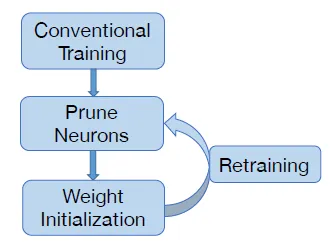

As your final task, create another model `CNN_MNIST_FNC` and `prune_and_train()` function where interactive prunning is implemented.

Then, run this function for 10 iterations with 10% random prunning for each iteration.

Finally, create the plot with accuracy as x-axis and sparsity as y-axis.

In [40]:
from abc import ABC, abstractmethod
from typing import Any


class BaseMetric(ABC):

    @abstractmethod
    def __call__(self, y_pred, y_ref) -> Any:
        raise NotImplementedError()



class AccuracyMetric(BaseMetric):

    def __init__(self) -> None:
        pass

    def reset(self) -> None:
        self.correct_predictions = 0
        self.total_samples = 0

    def update(self, y_pred: torch.Tensor, y_ref: torch.Tensor) -> None:
        predicted_classes = y_pred.argmax(dim=1)
        self.correct_predictions += (predicted_classes == y_ref).sum().item()
        self.total_samples += y_ref.size(0)

    @torch.no_grad()
    def __call__(self, y_pred: torch.Tensor, y_ref: torch.Tensor) -> torch.Tensor:
        """
        :param y_pred: tensor of shape (batch_size, num_of_classes) type float
        :param y_ref: tensor with shape (batch_size,) and type Long
        :return: scalar tensor with accuracy metric for batch
        """
        # Get the predicted class (index with the highest probability) for each sample
        predicted_classes = y_pred.argmax(dim=1)

        # Compare the predicted classes to the reference labels
        correct_predictions = (predicted_classes == y_ref).sum().item()

        # Calculate the accuracy
        accuracy = correct_predictions / y_ref.size(0)  # Divide by the batch size

        return torch.tensor(accuracy)

metric = AccuracyMetric()

In [41]:
def train_test_pass(model, train_loader, test_loader, optimizer, loss_function, device, num_epochs=5):
    history = {'train_loss': [], 'test_loss': [], 'accuracy': []}

    for epoch in range(1, num_epochs + 1):
        # Training
        model.train()
        total_loss = 0
        correct_train = 0
        total_train = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = output.max(1)
            total_train += target.size(0)
            correct_train += predicted.eq(target).sum().item()

            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))

        train_loss = total_loss / len(train_loader)
        train_accuracy = correct_train / total_train * 100.0
        history['train_loss'].append(train_loss)

        # Testing
        model.eval()
        test_loss = 0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = loss_function(output, target)

                test_loss += loss.item()
                _, predicted = output.max(1)
                total_test += target.size(0)
                correct_test += predicted.eq(target).sum().item()

            test_loss /= len(test_loader.dataset)
            test_accuracy = correct_test / total_test * 100.0
            history['test_loss'].append(test_loss)
            history['accuracy'].append(test_accuracy)

            print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
                test_loss, correct_test, len(test_loader.dataset), test_accuracy))

    return model, history['train_loss'], history['test_loss'], history['accuracy']


In [42]:
# Assuming CNN_MNIST_FNC is already defined
CNN_MNIST_FNC = CNN(input_shape=(1, 28, 28), num_of_cls=10).to(torch_device)

# Load the weights from a file
CNN_MNIST_FNC.load_state_dict(torch.load(model_save_path, map_location=torch_device))


<All keys matched successfully>

In [43]:
def prune_and_train(model: torch.nn.Module,
                    train_generator,
                    test_generator,
                    criterion,
                    metric: BaseMetric,
                    optimizer: torch.optim.Optimizer = None,
                    step: float = 0.1,
                    pruning_mode: str="random",
                    device = torch_device,):

    # Perform pruning based on the specified mode
    for name, module in model.named_children():
        if isinstance(module, nn.Conv2d):
            if pruning_mode == 'random':
                prune.random_unstructured(module, name='weight', amount=step)
            elif pruning_mode == 'l1':
                prune.l1_unstructured(module, name='weight', amount=step)
            elif pruning_mode == 'structured':
                # Example of structured pruning (you may need to adjust this based on your model architecture)
                prune.l1_unstructured(module, name='weight', amount=step)
                prune.remove(module, name='weight')  # Remove pruned connections for structured pruning


    # Calculate sparsity
    sparsity = calculate_sparsity(model)

    # Train for 1 epoch with train_generator
    model, _, loss_post_train, acc_post_train = train_one_epoch(model, train_generator, criterion, optimizer, device)

    # Evaluate with test_generator
    metric.reset()
    with torch.no_grad():
        model.eval()
        for inputs, labels in test_generator:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            metric.update(outputs, labels)

    return model, loss_post_train, acc_post_train, sparsity

def calculate_sparsity(model):
    total_params = 0
    zero_params = 0

    for name, module in model.named_children():
        if isinstance(module, nn.Conv2d):
            total_params += module.weight.nelement()
            zero_params += torch.sum(module.weight == 0).item()

    sparsity = zero_params / total_params
    return sparsity

def train_one_epoch(model, train_generator, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total_samples = 0

    for inputs, labels in train_generator:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total_samples += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    average_loss = total_loss / len(train_generator)
    accuracy = correct / total_samples

    return model, optimizer, average_loss, accuracy


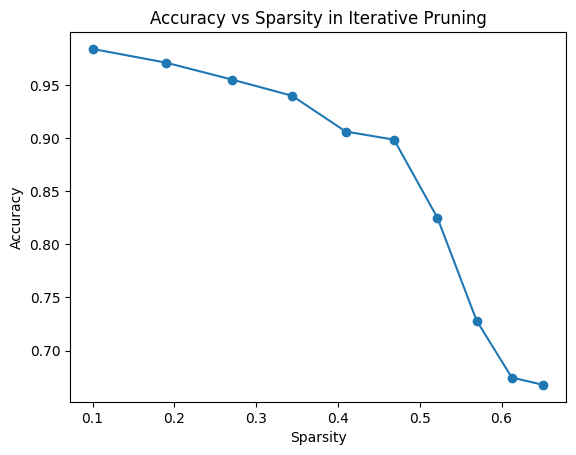

In [44]:
import matplotlib.pyplot as plt

# Assuming CNN_MNIST_FNC is already defined

# Lists to store data for plotting
accuracy_list = []
sparsity_list = []

for i in range(10):
  CNN_MNIST_FNC, loss, acc, sparsity = prune_and_train(CNN_MNIST_FNC, train_loader, test_loader, loss_fcn, metric, optimizer, step=0.1, device=torch_device)

  # Append data for plotting
  accuracy_list.append(acc)
  sparsity_list.append(sparsity)

# Plotting
plt.plot(sparsity_list, accuracy_list, marker='o')
plt.xlabel('Sparsity')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Sparsity in Iterative Pruning')
plt.show()


**Extention exercise**

Update the function with `prunning_mode` parameter that takes string `random` , `l1` or `structured` and perform tests of accuracy to sparsity ratio for each type of prunning. Plot the results.  

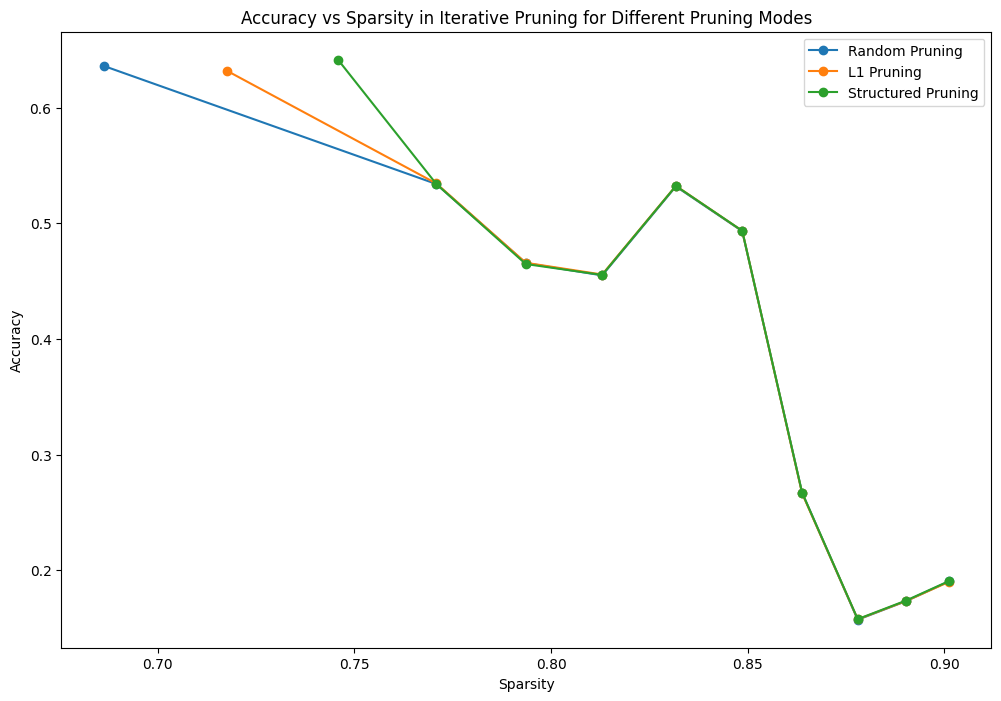

In [45]:
accuracy_list_random = []
sparsity_list_random = []
accuracy_list_l1 = []
sparsity_list_l1 = []
accuracy_list_structured = []
sparsity_list_structured = []

for i in range(10):
    metric = AccuracyMetric()

    # Random pruning
    CNN_MNIST_FNC, loss, acc, sparsity = prune_and_train(CNN_MNIST_FNC, train_loader, test_loader, loss_fcn, metric, optimizer, step=0.1, device=torch_device, pruning_mode='random')
    accuracy_list_random.append(acc)
    sparsity_list_random.append(sparsity)

    # L1 pruning
    CNN_MNIST_FNC, loss, acc, sparsity = prune_and_train(CNN_MNIST_FNC, train_loader, test_loader, loss_fcn, metric, optimizer, step=0.1, device=torch_device, pruning_mode='l1')
    accuracy_list_l1.append(acc)
    sparsity_list_l1.append(sparsity)

    # Structured pruning
    CNN_MNIST_FNC, loss, acc, sparsity = prune_and_train(CNN_MNIST_FNC, train_loader, test_loader, loss_fcn, metric, optimizer, step=0.1, device=torch_device, pruning_mode='structured')
    accuracy_list_structured.append(acc)
    sparsity_list_structured.append(sparsity)

# Plotting
plt.figure(figsize=(12, 8))

plt.plot(sparsity_list_random, accuracy_list_random, marker='o', label='Random Pruning')
plt.plot(sparsity_list_l1, accuracy_list_l1, marker='o', label='L1 Pruning')
plt.plot(sparsity_list_structured, accuracy_list_structured, marker='o', label='Structured Pruning')

plt.xlabel('Sparsity')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Sparsity in Iterative Pruning for Different Pruning Modes')
plt.legend()
plt.show()